In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import torch
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import cv2 as cv
import os
from PIL import Image

import torchvision.models as models
import torchvision
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# Any results you write to the current directory are saved as output.

In [2]:
def load_checkpoint(filepath):
    checkpoint = torch.load(filepath)
    model = checkpoint['model']
    model.load_state_dict(checkpoint['state_dict'])
    for parameter in model.parameters():
        parameter.requires_grad = True

    model.eval()
    return model

net = load_checkpoint('../input/checkpoint/checkpoint.pth')

In [3]:
net

NameError: name 'net' is not defined

In [4]:
device = torch.device('cuda:0')

root_dir = "./skin-cancer-mnist-ham10000"
root_dir = './skin-cancer-mnist-ham10000'
print(torch.cuda.is_available())
print( torch.cuda.get_device_name())
torch.cuda.empty_cache()
import torchvision.models as models
net = models.resnet50(pretrained=True)
# net = models.inception_v3(pretrained=True).to(device)
num_ftrs = net.fc.in_features
net.fc = torch.nn.Linear(num_ftrs, 7)

net = net.to(device)

True
GeForce GTX 950M


In [5]:
!ls

cell.jpg		Losses.txt	     skin-cancer-mnist-ham10000
Exploration-2.ipynb	MNIST		     super_mytraining.pt
Exploration.ipynb	mytraining.pt	     Testing_model.ipynb
feature_extraction.py	nrrd		     Untitled1.ipynb
ISIC_0027419.jpg	nrrd.zip	     Untitled.ipynb
jpd_to_nrrd.py		Preprocessing.ipynb  venv
kernel3c49ec2f38.ipynb	README.md
kernel58578ca456.ipynb	result.csv


In [6]:
print(net)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
skin_cancer_cells = pd.read_csv(root_dir + "/HAM10000_metadata.csv")
print(skin_cancer_cells)
all_ages = list(skin_cancer_cells.age)
is_valid = lambda x: not(np.isnan(x) or not x)
all_ages = list(filter(is_valid, all_ages))
avg = int(sum(all_ages)/len(all_ages))

         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


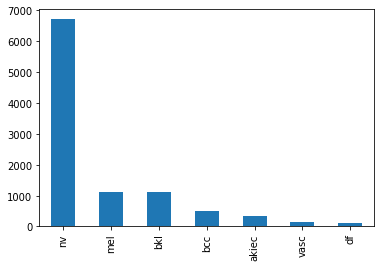

In [8]:
dx_dictionary = {
    "bcc": "basal cell carcinoma",
    "akiec":"Actinic keratoses and intraepithelial carcinoma / Bowen's disease",
    "bkl": "benign keratosis-like lesions",
    "df":"dermatofibroma",
    "mel":"melanoma",
    "nv":"melanocytic nevi",
    "vasc":"vascular lesions"
}

skin_cancer_cells["dx"].value_counts().plot(kind='bar')
weight = torch.cuda.FloatTensor([0.5, 0.3, 1, 0.1, 1, 7, 0.1])

In [9]:
skin_cancer_cells = skin_cancer_cells[["image_id", "dx"]]
print(len(skin_cancer_cells))

10015


In [10]:
#Initialize transformations for image augmentation
import torchvision.transforms as trf


transforms_pytorch = trf.Compose([
#     torchvision.transforms.RandomHorizontalFlip(),
#     torchvision.transforms.RandomRotation(20),
#     torchvision.transforms.RandomVerticalFlip()
    
    trf.RandomHorizontalFlip(),
    trf.RandomVerticalFlip(),
#     trf.Resize((300, 300)),
    trf.Resize((224, 224)),
#     trf.CenterCrop(256),
#     trf.RandomCrop(224),
    trf.ToTensor()
])

In [11]:
class SkinCancerDataset(Dataset):
    def __init__(self, dataframe, root_directory):
        self.df = dataframe
        self.dir = root_directory
        
    def get_index(self, label):
        labels = ["bcc","akiec","bkl","df","mel","nv","vasc"]
        return labels.index(label)
    
    def get_image(self, filename):
        directories = os.listdir(self.dir)
        directory = None
        for i in directories:
            if "." not in i and "{}.jpg".format(filename) in os.listdir("{}/{}".format(self.dir, i)):
                directory = i
        
#         img = Image.open()
        img = cv.cvtColor(
                    cv.imread("{}/{}/{}.jpg".format(self.dir, directory, filename)), cv.COLOR_BGR2RGB
                )
        
#         print(type(img))
        img = Image.fromarray(img)
#         print(type(img))
        img = transforms_pytorch(img)
        img = np.array(img)
        return img
#         return self.normalize(img)
    
    def normalize(self, img):
        return cv.normalize(img, None, alpha=0, beta=1, norm_type=cv.NORM_MINMAX, dtype=cv.CV_32F)
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image = self.df.iloc[index]
        img = torch.FloatTensor(self.get_image(image['image_id'])).to(device)
        idx = self.get_index(image['dx'])
        return img, idx 





In [12]:
dataset = SkinCancerDataset(skin_cancer_cells, root_dir)
batch_size = 8
validation_split = .2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                           sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                                sampler=valid_sampler)

In [13]:
len(train_loader), len(validation_loader)

(1002, 251)

In [14]:
class CancerNet(torch.nn.Module):
    
    def __init__(self):
        super(CancerNet, self).__init__()
        self.fc1 = torch.nn.Linear(1000, 400)
        self.fc2 = torch.nn.Linear(400, 140)
        self.act = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(140, 7)
        
    
    def forward(self, x):
        x = inception(x.cuda())
        x = self.act(self.fc1(x))
        x = self.act(self.fc2(x))
        x = self.act(self.fc3(x))
        return x
    
class SuperCancerNet(torch.nn.Module):
    def __init__(self):
        super(SuperCancerNet, self).__init__()
        
        # First Convolutional
        self.relu = torch.nn.ReLU()
        self.sigmoid = torch.nn.Sigmoid()        
        
        self.conv1_1 = torch.nn.Conv2d(in_channels=3, out_channels=6, kernel_size=3)
        self.conv1_2 = torch.nn.Conv2d(in_channels=6, out_channels=6, kernel_size=3)
        self.norm1 = torch.nn.BatchNorm2d(6)
        
        self.drop1 = torch.nn.Dropout2d(0.4)
        self.pool1 = torch.nn.MaxPool2d(kernel_size=2)
        
        # Second Convolutional
        self.conv2_1 = torch.nn.Conv2d(in_channels=6, out_channels=10, kernel_size=3, padding=1)
        self.conv2_2 = torch.nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=1)
        self.norm2 = torch.nn.BatchNorm2d(10)
        self.drop2 = torch.nn.Dropout2d(0.4)
        self.pool2 = torch.nn.MaxPool2d(kernel_size=2)
        
        
    
        self.fc1 = torch.nn.Linear(in_features=10 * 11 * 11, out_features=256)
        self.fc2 = torch.nn.Linear(in_features=256, out_features=7)
        
    
    def forward(self, x):
        x = self.conv1_2(self.conv1_1(x))
        x = self.norm1(x)
        x = self.drop1(x)
        x = self.pool1(x)
        x = self.relu(x)
        
        x = self.conv2_2(self.conv2_1(x))
        x = self.norm2(x)
        x = self.drop2(x)
        x = self.pool2(x)
        x = self.relu(x)
        
        x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)

        return x

In [15]:
print(torch.cuda.memory_allocated())

94337536


In [16]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-6)
# losses = []
accuracies = []
trainings_loss = []
validation_loss = []

In [17]:
# from IPython.display import FileLink

# FileLink(r'checkpoint.pth')

In [18]:
import tqdm

In [20]:
for j in range(25):
#     torch.save(net.state_dict(), './model.pth')
    whole_loss = 0.0
    count_train = 0
    trainings_loss_tmp = []
    net.train()
    for data in tqdm.tqdm(train_loader):
        inp, labels = data
#         print(inp.shape)
        optimizer.zero_grad()
#         inp = inp.transpose(1, 3).transpose(2, 3)
#         print(inp.shape)
        inp = inp.to(device)
        labels = labels.to(device)
        torch.cuda.empty_cache()
        fws = net.forward(inp)
        loss = criterion(fws, labels.to(device))
        loss.backward()
        optimizer.step()
        trainings_loss_tmp.append(loss.item())
        count_train += 1
        if count_train >= 250:
            count_train = 0
            mean_trainings_loss = np.mean(trainings_loss_tmp)
            trainings_loss.append(mean_trainings_loss)
            print('trainings error:', mean_trainings_loss)
    total  = 0
    correct = 0
    count_val = 0
    net.eval()
    validation_loss_tmp = []
    for data in tqdm.tqdm(validation_loader):
        inp, labels = data
#         inp = inp.transpose(1, 3).transpose(2, 3)
        inp = inp.to(device)
        labels = labels.to(device)
        outputs = net.forward(inp)
        loss = criterion(outputs, labels)
        validation_loss_tmp.append(loss.item())
        
        count_val += 1
        if count_val >= 60:
            count_val = 0
            mean_val_loss = np.mean(validation_loss_tmp)
            validation_loss.append(mean_val_loss)
            print('validation error:', mean_val_loss)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted.to(device) == labels.to(device)).sum().item()
    print("Accuracy: ", correct/(total))
    accuracies.append(correct/(total))
    checkpoint = {
        'model': net,
        'state_dict': net.state_dict(),
        'optimizer' : optimizer.state_dict()
    }
    torch.save(checkpoint, 'checkpoint.pth'.format(j))
    torch.cuda.empty_cache()


 15%|█▌        | 152/1002 [01:44<09:07,  1.55it/s]


 25%|██▍       | 250/1002 [02:50<08:11,  1.53it/s]

trainings error: 1.8446789875030518



 40%|████      | 401/1002 [04:29<06:32,  1.53it/s]


 50%|████▉     | 500/1002 [05:38<05:59,  1.40it/s]

trainings error: 1.7104332449436188



 65%|██████▍   | 651/1002 [07:18<04:35,  1.27it/s]


 75%|███████▍  | 750/1002 [08:38<03:29,  1.20it/s]

trainings error: 1.5929362667401632



 90%|████████▉ | 901/1002 [10:37<01:19,  1.28it/s]


100%|█████████▉| 1000/1002 [11:56<00:01,  1.28it/s]

trainings error: 1.4976312577724458



100%|██████████| 1002/1002 [11:58<00:00,  1.40it/s]

  0%|          | 1/251 [00:00<03:00,  1.39it/s]


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 1.96 GiB total capacity; 1.06 GiB already allocated; 1.62 MiB free; 28.85 MiB cached)

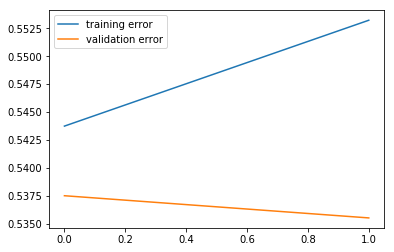

In [20]:
import matplotlib.pyplot as plt

plt.plot(trainings_loss, label = 'training error')
plt.plot(validation_loss, label = 'validation error')
plt.legend()
plt.show()